In [1]:
import numpy as np
import numpy.linalg as lin
import numpy.random as npr 
import scipy.optimize as sco
import scipy.stats as si 
import time
from scipy import interpolate 
from scipy.linalg import expm
from scipy.fftpack import fft, ifft
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'

In [2]:
# Parameter Input
S0 = 100.0 # ini stock price
G = 100.0 # garantee level
T = 10 # maturity
m = 0.02 # R&E fee
me = 0.01441466502048007 # rider charge
N, X = 1024, 7.5 # FST param.
I, M = 1000000, 10 # Monte Carlo param.

r = [0.04, 0.01] # risk-free interest rate
# drift = [0.05, 0.02] # drift
sigma = [0.1, 0.2] # volatility
lamb = [0.1, 0.2]
mu = [0.2, -0.1] # jump mean
nu = [0.1, 0.2] # jump volatility

A = np.array([[-0.4, 0.4], [0.3, -0.3]]) # transition matrix
Pi = np.array([[0.9999], [0.0001]]) # ini state

In [3]:
# PV of Zero-coupon bond
def z(r, T, A, Pi):
    r1, r2 = r[0], r[1]
    dr = r1 - r2
    D = np.array([[1, 0], [0, 0]])
    E = expm((A - dr * D) * T)
    One = np.ones((2, 1))
    Z = np.exp(-r2 * T) * Pi.T.dot(E.dot(One))
    return float(Z)
# Rho1 of Zero-coupon bond
def rho1_z(r, T, A, Pi):
    r1, r2 = r[0], r[1]
    dr = r1 - r2
    D = np.array([[1, 0], [0, 0]])
    E = expm((A - dr * D) * T)
    One = np.ones((2, 1))
    Z = -np.exp(-r2 * T) * Pi.T.dot(T * D.dot(E.dot(One))) / 100
    return float(Z)
# Rho2 of Zero-coupon bond
def rho2_z(r, T, A, Pi):
    r1, r2 = r[0], r[1]
    dr = r1 - r2
    D = np.array([[1, 0], [0, 0]])
    E = expm((A - dr * D) * T)
    One = np.ones((2, 1))
    Z1 = np.exp(-r2 * T) * Pi.T.dot(T * D.dot(E.dot(One)))
    Z2 = -T * np.exp(-r2 * T) * Pi.T.dot(E.dot(One))
    Z = (Z1 + Z2) / 100
    return float(Z)
print('z(10) = %.16f' % z(r, T, A, Pi)) # 0.7784180374597731
print('rho1_z(10) = %.16f' % rho1_z(r, T, A, Pi)) # -0.0778336802081909
print('rho2_z(10) = %.16f' % rho2_z(r, T, A, Pi)) # -0.0000081235377864

z(10) = 0.7784180374597731
rho1_z(10) = -0.0778336802081909
rho2_z(10) = -0.0000081235377864


In [4]:
# Stochastic Motality Risk
def b(t):
    a, sig = 0.08000149236993707, 0.010468669959318862
    b = -np.sqrt(a ** 2 + 2 * sig ** 2)
    c = (b + a) / 2
    d = (b - a) / 2
    B = (1 - np.exp(b * t)) / (c + d * np.exp(b * t))
    return B
def s(t):
    ini = 0.00495 # aged 50 years old in 2017
    # ini = 0.01164 # aged 60 years old in 2017
    # ini = 0.02255 # aged 70 years old in 2017
    a, sig = 0.08000149236993707, 0.010468669959318862
    b = -np.sqrt(a ** 2 + 2 * sig ** 2)
    c = (b + a) / 2
    d = (b - a) / 2
    # A = 0
    # S_feller = np.exp(A + B(t)*ini)
    S = np.exp((1 - np.exp(b * t)) / (c + d * np.exp(b * t)) * ini)
    return S
print('s(0) = %.16f' % s(0)) # 1.0
print('s(10) = %.16f' % s(15)) # 0.8672053048004046

s(0) = 1.0000000000000000
s(10) = 0.8672053048004046


In [5]:
def rsmjd_gmmb_mc(S0, G, T, r, sigma, m, me, lamb, mu, nu, A, Pi, M, I):
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    l1, l2 = A[0, 1], A[1, 0]
    mu1, mu2 = mu[0], mu[1]
    nu1, nu2 = nu[0], nu[1]
    lamb1, lamb2 = lamb[0], lamb[1]
    drift1 = r1 - m - lamb1 * (np.exp(mu1 + 0.5 * nu1 ** 2) - 1) - 0.5 * sigma1 ** 2
    drift2 = r2 - m - lamb2 * (np.exp(mu2 + 0.5 * nu2 ** 2) - 1) - 0.5 * sigma2 ** 2  
    if Pi[0] > Pi[1]:
        Ini_State = 1.0
    else:
        Ini_State = 2.0
    F = np.zeros((T + 1, I))
    F[0] = S0
    cf = np.zeros((T + 1, I)) 
    for t in range(T + 1):
        for i in range(I):
            LogStock = float(np.log(S0))
            Cur_Time = 0.0
            Cur_State = Ini_State
            tau1 = 0.0
            while Cur_Time < t:
                p = npr.uniform(0, 1)
                if Cur_State == 1:
                    ExpRV = -1 * np.log(p) / l1
                else:
                    ExpRV = -1 * np.log(p) / l2
                if Cur_Time + ExpRV < t and Cur_State == 1:
                    tau1 = tau1 + ExpRV
                else:
                    if Cur_State == 1:
                        tau1 = tau1 + t - Cur_Time
                Cur_Time = Cur_Time + ExpRV
                if Cur_State == 1:
                    Cur_State = 2
                else:
                    Cur_State = 1
            J1 = 0
            Nt1 = npr.poisson(lamb1 * tau1)
            if Nt1 > 0:
                for j1 in range(Nt1):
                    J1 = J1 + npr.normal(mu1, nu1)
            J2 = 0
            Nt2 = npr.poisson(lamb2 * (t - tau1))
            if Nt2 > 0:
                for j2 in range(Nt2):
                    J2 = J2 + npr.normal(mu2, nu2)
            SimRand = float(npr.standard_normal())
            LogFund = LogStock + drift1 * tau1 + drift2 * (t - tau1) + SimRand * np.sqrt(tau1 * sigma1 ** 2 + (t - tau1) * sigma2 ** 2) + J1 + J2
            F[t, i] = np.exp(LogFund)
            if t < T:
                cf[t, i] = np.exp(-1 * (r1 * tau1 + r2 * (t - tau1))) * np.exp(LogFund) * me * s(t)
            else:
                cf[t, i] = np.exp(-1 * (r1 * tau1 + r2 * (t - tau1))) * np.maximum(0, G - np.exp(LogFund))
    Gmmb = np.mean(s(T) * cf[-1] - np.sum(cf[:-1], 0))
    return (np.mean(cf[-1]), Gmmb)

start = time.clock()
Results = rsmjd_gmmb_mc(S0, G, T, r, sigma, m, me, lamb, mu, nu, A, Pi, M, I)
print('Put_MC = %.16f' % Results[0]) # 15.8541378392054515
print('GMMB_MC = %.16f' % Results[1]) # 1.8643727149974147
elapsed = (time.clock() - start)
print("Time used:", elapsed)

Put_MC = 15.8541378392054515
GMMB_MC = 1.8643727149974147
Time used: 372.01107039999624


In [17]:
def rsmjd_put_fst(S0, G, T, r, sigma, m, lamb, mu, nu, A, Pi, N, X):
    # parameter
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    A11, A12, A21, A22 = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
    mu1, mu2 = mu[0], mu[1]
    nu1, nu2 = nu[0], nu[1]
    lamb1, lamb2 = lamb[0], lamb[1]
    # Real space
    x_min, x_max = -X, X
    dx = (x_max - x_min) / (N - 1)
    x = np.linspace(x_min, x_max, N)
    # Fourier space
    epsilon = 0.0001
    w_max = np.pi / dx
    dw = 2 * w_max / N
    w = np.hstack((np.arange(0, w_max + epsilon, dw), np.arange(-w_max + dw, -dw + epsilon, dw)))
    # Payoff function at time T
    ST = S0 * np.exp(x)
    payoff_p = np.maximum(G - ST, 0)
    # Matrix characteristic funciton
    drift1 = r1 - m - lamb1 * (np.exp(mu1 + 0.5 * nu1 ** 2) - 1) - 0.5 * sigma1 ** 2
    drift2 = r2 - m - lamb2 * (np.exp(mu2 + 0.5 * nu2 ** 2) - 1) - 0.5 * sigma2 ** 2  
    psi1 = 1j * drift1 * w - 0.5 * (sigma1 * w) ** 2 + lamb1 * (np.exp(1j * mu1 * w - 0.5 * (nu1 * w) ** 2) - 1) - r1
    psi2 = 1j * drift2 * w - 0.5 * (sigma2 * w) ** 2 + lamb2 * (np.exp(1j * mu2 * w - 0.5 * (nu2 * w) ** 2) - 1) - r2
    Psi = np.zeros((N, 2, 2), dtype=complex)
    for i in range(N):
        Psi[i, 0] = [A11 + psi1[i], A12]
        Psi[i, 1] = [A21, A22 + psi2[i]]
    char = np.array([expm(i * T) for i in Psi])
    # FST method
    p1 = ifft((char[:, 0, 0] + char[:, 0, 1]) * fft(payoff_p)).real
    p2 = ifft((char[:, 1, 0] + char[:, 1, 1]) * fft(payoff_p)).real
    # Interpolate prices
    f1 = interpolate.PchipInterpolator(ST, p1)
    f2 = interpolate.PchipInterpolator(ST, p2)
    P = Pi.T.dot(np.array([[f1(S0)], [f2(S0)]]))
    return float(P) # 13.8429656013946278
print('Put_FST = %.16f' % rsmjd_put_fst(S0, G, T, r, sigma, m, lamb, mu, nu, A, Pi, N, X))

Put_FST = 15.8587171702497667


In [18]:
def rsmjd_gmmb_fst(S0, G, T, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X):
    P = rsmjd_put_fst(S0, G, T, r, sigma, m, lamb, mu, nu, A, Pi, N, X)
    # parameter
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    A11, A12, A21, A22 = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
    mu1, mu2 = mu[0], mu[1]
    nu1, nu2 = nu[0], nu[1]
    lamb1, lamb2 = lamb[0], lamb[1]
    # Real space
    x_min, x_max = -X, X
    dx = (x_max - x_min) / (N - 1)
    x = np.linspace(x_min, x_max, N)
    # Fourier space
    epsilon = 0.0001
    w_max = np.pi / dx
    dw = 2 * w_max / N
    w = np.hstack((np.arange(0, w_max + epsilon, dw), np.arange(-w_max + dw, -dw + epsilon, dw)))
    ST = S0 * np.exp(x)
    # calculate rider charges
    Re = []
    for t in range(T):
        # Payoff function at time T
        payoff_r = me * ST * s(t)
        # Matrix characteristic funciton
        drift1 = r1 - m - lamb1 * (np.exp(mu1 + 0.5 * nu1 ** 2) - 1) - 0.5 * sigma1 ** 2
        drift2 = r2 - m - lamb2 * (np.exp(mu2 + 0.5 * nu2 ** 2) - 1) - 0.5 * sigma2 ** 2  
        psi1 = 1j * drift1 * w - 0.5 * (sigma1 * w) ** 2 + lamb1 * (np.exp(1j * mu1 * w - 0.5 * (nu1 * w) ** 2) - 1) - r1
        psi2 = 1j * drift2 * w - 0.5 * (sigma2 * w) ** 2 + lamb2 * (np.exp(1j * mu2 * w - 0.5 * (nu2 * w) ** 2) - 1) - r2
        Psi = np.zeros((N, 2, 2), dtype=complex)
        for i in range(N):
            Psi[i, 0] = [A11 + psi1[i], A12]
            Psi[i, 1] = [A21, A22 + psi2[i]]
        char = np.array([expm(i * t) for i in Psi])
        # FST method
        re1 = ifft((char[:, 0, 0] + char[:, 0, 1]) * fft(payoff_r)).real
        re2 = ifft((char[:, 1, 0] + char[:, 1, 1]) * fft(payoff_r)).real
        # Interpolate prices
        f1 = interpolate.PchipInterpolator(ST, re1)
        f2 = interpolate.PchipInterpolator(ST, re2)
        Re.append(Pi.T.dot(np.array([[f1(S0)], [f2(S0)]])))
    Re = np.sum(Re)
    # calculate GMMB loss
    Loss = s(T) * P - Re
    return float(Loss)  # 0.0000000000005329
start = time.clock()
print('GMMB_FST = %.16f' % rsmjd_gmmb_fst(S0, G, T, r, sigma, m, me, lamb, mu, nu, A, Pi, N, X))
elapsed = (time.clock() - start)
print("Time used:", elapsed)

GMMB_FST = 1.8689340622882540
Time used: 3.1439466000010725


In [16]:
def mjdgreeks_fst(S0, K, r, T, si, q, la, mu, nu, N, x):
    x_max = x
    x_min = -x
    dx = (x_max - x_min) / (N-1)
    x = np.linspace(x_min, x_max, N)

    epsilon = 0.0001
    w_max = np.pi / dx
    dw = 2 * w_max / N
    w = np.hstack((np.arange(0, w_max+epsilon, dw), np.arange(-w_max+dw, -dw+epsilon, dw)))

    ST = S0 * np.exp(x)
    CT = np.maximum(ST - K, 0)
    PT = np.maximum(K - ST, 0)

    rj = la * (np.exp(mu + 0.5 * nu**2) - 1) 
    psi = 1j*(r-q-0.5*si**2-rj)*w - 0.5*(si*w)**2 + la*(np.exp(1j*mu*w-0.5*(nu*w)**2)-1) - r
    char = np.exp(psi * T) # char_exp_factor

    de_c = (ifft(1j*w * fft(CT)*char)/ST).real
    ga_c = (ifft(-(1j*w+w**2) * fft(CT)*char)/ST**2).real
    rh_c = ifft((1j*w-1)*T * fft(CT)*char).real
    ve_c = ifft(-(1j*w+w**2)*si*T * fft(CT)*char).real
    la_c = ifft((-1j*w*(np.exp(mu-0.5*nu**2)-1)+np.exp(1j*mu*w+0.5*(nu*w)**2)-1)*T * fft(CT)*char).real
    mu_c = ifft(-1j*w*la*(np.exp(mu-0.5*nu**2)-np.exp(1j*mu*w+0.5*(nu*w)**2))*T*fft(CT)*char).real
    nu_c = ifft((-1j*w*la*nu*np.exp(mu-0.5*nu**2)-nu*w**2*la*np.exp(1j*mu*w+0.5*(nu*w)**2))*T*fft(CT)*char).real

    # de_p = (ifft(1j*w*fft(PT)*char)/ST).real
    # ga_p = (ifft(-(1j*w+w**2)*fft(PT)*char)/ST**2).real
    # rh_p = ifft((1j*w-1)*T*fft(PT)*char).real
    # ve_p = ifft(-(1j*w+w**2)*sigma*T*fft(PT)*char).real
    # lamb_p = ifft((-1j*w*(a-1)+d-1)*T*fft(PT)*char).real
    # mu_p = ifft(-1j*w*lamb*(a-d)*T*fft(PT)*char).real
    # nu_p = ifft((-1j*w*lamb*nu*a-nu*w**2*lamb*d)*T*fft(PT)*char).real
    
    f = interpolate.PchipInterpolator(ST, de_c)
    De_C = f(S0) + 0.0
    f = interpolate.PchipInterpolator(ST, ga_c)
    Ga_C = f(S0) + 0.0
    f = interpolate.PchipInterpolator(ST, rh_c)
    Rh_C = f(S0) + 0.0
    f = interpolate.PchipInterpolator(ST, ve_c)
    Ve_C = f(S0) + 0.0
    f = interpolate.PchipInterpolator(ST, la_c)
    La_C = f(S0) + 0.0
    f = interpolate.PchipInterpolator(ST, mu_c)
    Mu_C = f(S0) + 0.0
    f = interpolate.PchipInterpolator(ST, nu_c)
    Nu_C = f(S0) + 0.0

    # f = interpolate.PchipInterpolator(ST, de_p)
    # De_P = f(S0) + 0.0
    # f = interpolate.PchipInterpolator(ST, ga_p)
    # Ga_P = f(S0) + 0.0
    # f = interpolate.PchipInterpolator(ST, rh_p)
    # Rh_P = f(S0) + 0.0
    # f = interpolate.PchipInterpolator(ST, ve_p)
    # Ve_P = f(S0) + 0.0
    # f = interpolate.PchipInterpolator(ST, lamb_p)
    # Lamb_P = f(S0) + 0.0
    # f = interpolate.PchipInterpolator(ST, mu_p)
    # Mu_P = f(S0) + 0.0
    # f = interpolate.PchipInterpolator(ST, nu_p)
    # Nu_P = f(S0) + 0.0

    # return ((De_C, Ga_C, Rh_C, Ve_C, Lamb_C, Mu_C, Nu_C), (De_P, Ga_P, Rh_P, Ve_P, Lamb_P, Mu_P, Nu_P))
    return (De_C, Ga_C, Rh_C, Ve_C, La_C, Mu_C, Nu_C)
    # return (De_C, Ga_C, Rh_C, Ve_C, Lamb_C)

In [17]:
mjdgreeks_fst(S0, K, r, T, si, q, la, mu, nu, 512, x)

(0.6615612742388046,
 0.0024830633115095805,
 255.35641324139092,
 37.245912968266374,
 121.28682255801083,
 -27.912863453650846,
 8.884482064945294)

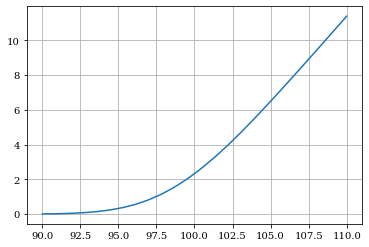

In [34]:
S0 = np.linspace(90, 110)
P = []
for i in range(50):
    price = mjdprice_fst(S0[i], 100, 0.06, 0.1, 0.12, 0.01, 0.15, -1.08, 0.3, N, x)[0]
    P.append(price)
plt.plot(S0, P)
plt.grid()

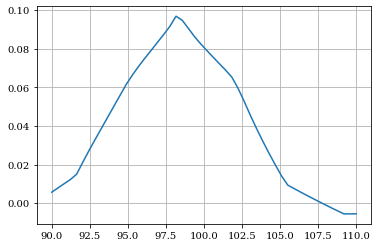

In [42]:
S0 = np.linspace(90, 110)
P = []
for i in range(50):
    price = mjdgreeks_fst(S0[i], 100, 0.06, 0.1, 0.12, 0.01, 0.15, -1.08, 0.3, 512, x)[1]
    P.append(price)
plt.plot(S0, P)
plt.grid()

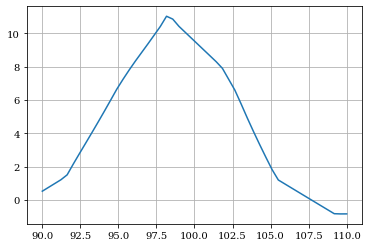

In [43]:
S0 = np.linspace(90, 110)
P = []
for i in range(50):
    price = mjdgreeks_fst(S0[i], 100, 0.06, 0.1, 0.12, 0.01, 0.15, -1.08, 0.3, 512, x)[3]
    P.append(price)
plt.plot(S0, P)
plt.grid()